In [1]:
def nearest_node(point, coords):
    """
    Find the nearest node to a point and return the corresponding node label

    ### Parameters
    ----------
    node : tuple
        The coordinates of a point
    coords : list
        A list of coordinates of points

    ### Returns
    -------
    tuple
        The coordinates of the nearest node
    """
    dist = float("inf")
    nearest_node = None
    lat, long = point
    for y, x in coords:
        euclidean_distance = (lat - y) ** 2 + (long - x) ** 2
        if euclidean_distance < dist:
            dist = euclidean_distance
            nearest_node = (y, x)
    return nearest_node

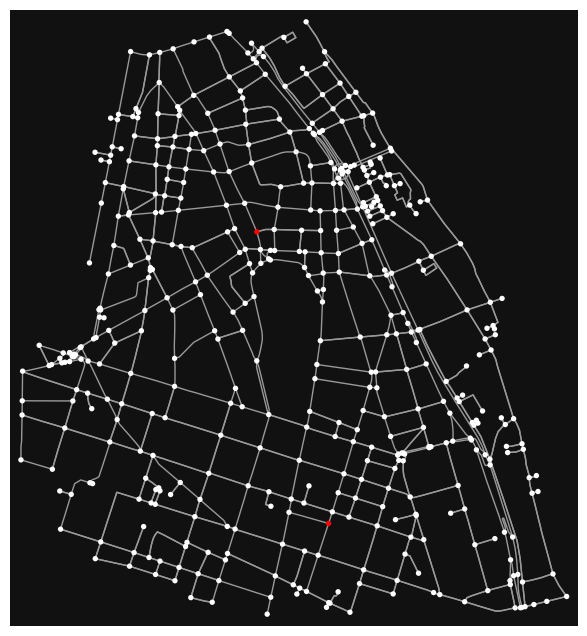

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
import random
import osmnx as ox

G = ox.graph_from_place("Hoàn Kiếm, Hà Nội, Vietnam", network_type='drive')

co = [(data["y"], data["x"]) for _, data in G.nodes(data=True)]


colors = ["w"] * len(co)

rd_node_1, rd_node_2 = random.choices(co, k=2)

colors[co.index(rd_node_1)] = "r"

colors[co.index(rd_node_2)] = "r"

# Display random point

ox.plot_graph(G, node_color=colors)

In [147]:
from collections import defaultdict, deque
from heapq import heappop, heappush


class Graph:
    def __init__(self, G):
        self.graph = defaultdict(list)
        self.G = G

    def addEdge(self, u, v, w):
        self.graph[u].append((v, w))

    def dijkstra(self, start, end):
        visited = defaultdict(bool)
        dist = defaultdict(lambda: float("inf"))
        trace = defaultdict(int)
        dist[start] = 0
        pq = [(0, start)]
        while pq:
            _, node = heappop(pq)
            if visited[node]:
                continue
            visited[node] = True
            if node == end:
                break
            for neighbor, weight in self.graph[node]:
                if dist[neighbor] > dist[node] + weight:
                    dist[neighbor] = dist[node] + weight
                    trace[neighbor] = node
                    heappush(pq, (dist[neighbor], neighbor))
        path = deque()
        while end != start:
            path.appendleft((self.G.nodes[end]["y"], self.G.nodes[end]["x"]))
            end = trace[end]
        path.appendleft((self.G.nodes[start]["y"], self.G.nodes[start]["x"]))
        return list(path)

In [148]:
g = Graph(G)
for u, v, attrs in list(G.edges.data()):
    g.addEdge(u, v, attrs["length"])
G.nodes

In [149]:
start = random.choice(list(g.graph.keys()))
end = random.choice(list(g.graph.keys()))
start, end

(320410429, 98043908)

In [158]:
coords = [(data["y"], data["x"], key) for key, data in G.nodes(data=True)]
coords

[(21.025479, 105.8532306, 75617751),
 (21.0314055, 105.8510021, 75617760),
 (21.0302875, 105.8538796, 75617763),
 (21.0249186, 105.8551489, 75618029),
 (21.0323034, 105.8513234, 75618721),
 (21.0323117, 105.8507011, 75619046),
 (21.0322647, 105.8519096, 75619049),
 (21.0304469, 105.8474828, 81794043),
 (21.033072, 105.8518914, 81794511),
 (21.0347124, 105.8521568, 81794512),
 (21.0348609, 105.853446, 81794516),
 (21.0352977, 105.8500374, 81795093),
 (21.0340786, 105.8506755, 81795094),
 (21.0372334, 105.8546854, 81796035),
 (21.0244868, 105.8571509, 81817652),
 (21.0339304, 105.8520456, 84782074),
 (21.0340044, 105.849926, 84782080),
 (21.0338086, 105.8479466, 84782082),
 (21.0337207, 105.84701, 84782084),
 (21.0336305, 105.845895, 84782085),
 (21.0335837, 105.8454757, 84782086),
 (21.0365581, 105.8470901, 84782318),
 (21.0355553, 105.8470217, 84782319),
 (21.034437, 105.8469984, 84782320),
 (21.0352811, 105.8493988, 84782621),
 (21.0354784, 105.8475599, 84782624),
 (21.0367611, 105.84

In [150]:
path = g.dijkstra(start, end)
path

[(21.04004, 105.8513909),
 (21.0385754, 105.8523386),
 (21.0390552, 105.8532212),
 (21.0382553, 105.8538807),
 (21.0377085, 105.8543141),
 (21.037154, 105.8534585),
 (21.0397168, 105.8514505),
 (21.0394785, 105.8511629),
 (21.0389354, 105.8500426),
 (21.0382257, 105.8485763),
 (21.0377886, 105.8479192),
 (21.0376532, 105.8480008),
 (21.037451, 105.8479737),
 (21.0366502, 105.8478052),
 (21.0362416, 105.8477224),
 (21.0354784, 105.8475599),
 (21.0349989, 105.8474866),
 (21.0343689, 105.8473831),
 (21.0337414, 105.8472542),
 (21.0337207, 105.84701),
 (21.0326329, 105.8469055),
 (21.0319829, 105.8467087),
 (21.0316084, 105.8467968),
 (21.0315022, 105.846789),
 (21.03122, 105.8467249),
 (21.0299584, 105.846568),
 (21.0291808, 105.8464255),
 (21.0275442, 105.8459871),
 (21.0263771, 105.8456154)]

In [152]:
rd_node_1 = (21.0216, 105.8414)

In [181]:
co.index(rd_node_1), co.index(rd_node_2)

(19, 112)

In [154]:
diff = 0
for i in range(1):
    # random_node_1 = (rd_node_1[0] + rand(), rd_node_1[1] + rand())
    # random_node_2 = (rd_node_2[0] + rand(), rd_node_2[1] + rand())
    nr_1 = ox.nearest_nodes(G, Y=rd_node_1[0], X=rd_node_1[1])
    print(G.nodes[nr_1])
#     if to_ll(nr_1) != nearest_node(random_node_1, co) or to_ll(nr_2) != nearest_node(
#         random_node_2, co
#     ):
#         diff += 1
# diff

{'y': 21.021558, 'x': 105.8430971, 'street_count': 3}
